<a href="https://colab.research.google.com/github/yhtang/SINN/blob/main/OU_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed May  8 17:24:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               Off |   00000000:A8:00.0 Off |                    0 |
| N/A   31C    P0             48W /  350W |       0MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [3]:
device = torch.device('cuda')

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

200.0
(1500, 400)
(400, 400) (400, 400)
CPU times: user 354 ms, sys: 3.92 ms, total: 358 ms
Wall time: 361 ms


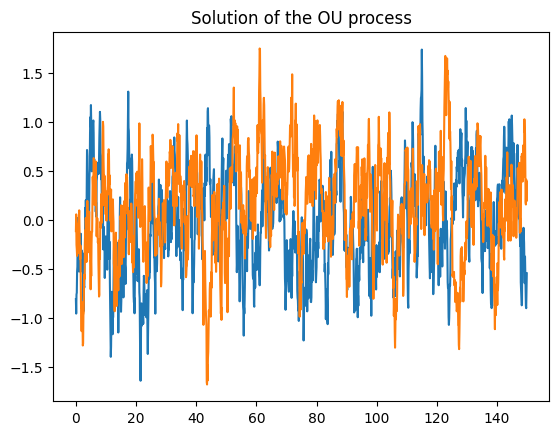

In [8]:
%%time
#### Generating SINN training data by solving SDE

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


#### Parameters 
sigma = 0.5
gamma = 1                            # coupling constant 
beta = 1                             # Inverse temperature, i.e. T=1/beta
dt = 0.01                            # Step-size of the SDE solver 
delta_t = 0.1                        # Step-size of the temporally coarse-grained path
batch = 400                          # Batch size 
sec_length = 400                     # Length of the input sequence 


#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length)          
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q_store = np.zeros([t_store.size+1,batch])
q=np.zeros((2,batch))
# solve SDE
j=1
for i in range(1,length):
    q[1,:] = q[0,:] -gamma*q[0,:]*dt+ np.random.randn(1,batch)*np.sqrt(2*dt*sigma**2)
    if i % gap ==0:
        q_store[j,:]=q[1,:]
        j=j+1
    q[0,:]=q[1,:]
Toss=int(t_store.size/4)        
q_store=q_store[Toss:-1,:]         
print(q_store.shape)


plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,i])
# plt.legend()
plt.title("Solution of the OU process")



#### Constructing the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj=q_store[0:sec_length,:]
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
pdf_exact=np.exp(-x**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
print(ini.shape, Traj.shape)

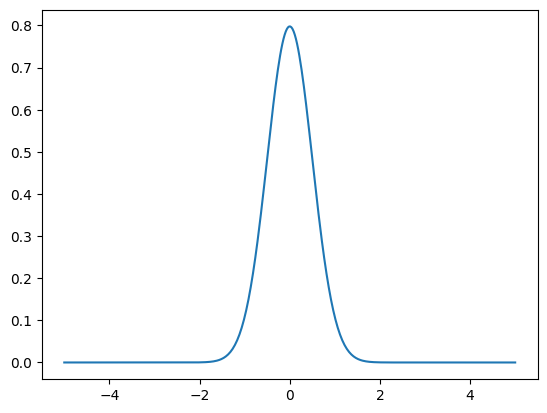

In [9]:
plt.plot(x,pdf_exact)

In [10]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)

Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch,1)).to(device)
pdf_exact = pdf_exact.astype(np.float32)
PDF_exact=torch.from_numpy(pdf_exact).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 1]) torch.float32


In [11]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_q2 = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)
loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_exact = make_loss('pdf', PDF_exact, lower=-5, upper=5, n=N, bw=None, device=device)

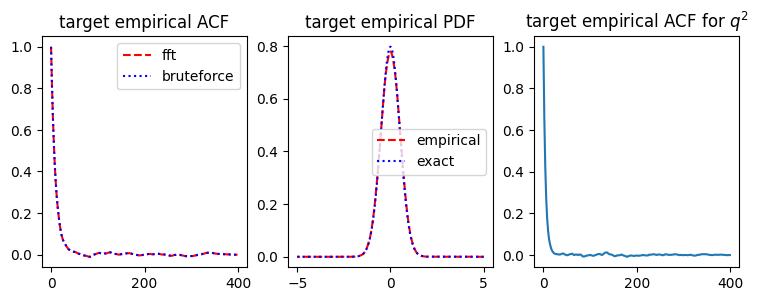

In [12]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].plot(loss_acf_fft._target.cpu(),'r--', label='fft')
axs[0].plot(loss_acf_bruteforce._target.cpu(),'b:', label='bruteforce')
axs[0].set_title('target empirical ACF')
axs[0].legend()

x_grid=-np.linspace(-5,5,num=sec_length)
axs[1].plot(x_grid, loss_pdf_empirical._target.cpu(),'r--',label='empirical')
axs[1].plot(x_grid, loss_pdf_exact._target.cpu(),'b:',label='exact')
axs[1].set_title('target empirical PDF')
axs[1].legend()

axs[2].plot(loss_acf_q2._target.cpu())
axs[2].set_title(r'target empirical ACF for $q^2$')

plt.show()

In [13]:
### Defining SINN model 
net = SINN(1, 16, 2, 1,'GRU').to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [14]:
from prettytable import PrettyTable

In [15]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [16]:
count_parameters(net)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| arch.weight_ih_l0 |     48     |
| arch.weight_hh_l0 |    768     |
|  arch.bias_ih_l0  |     48     |
|  arch.bias_hh_l0  |     48     |
| arch.weight_ih_l1 |    768     |
| arch.weight_hh_l1 |    768     |
|  arch.bias_ih_l1  |     48     |
|  arch.bias_hh_l1  |     48     |
|   readout.weight  |     16     |
|    readout.bias   |     1      |
+-------------------+------------+
Total Trainable Params: 2561


2561

In [17]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_exact(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0002 and loss_val<=0.0002:
            break
print('Training finished')

[0]-th step loss: 0.2084, 0.2061
[50]-th step loss: 0.0078, 0.0072
[100]-th step loss: 0.0011, 0.0013
[150]-th step loss: 0.0006, 0.0005
[200]-th step loss: 0.0003, 0.0003
[250]-th step loss: 0.0003, 0.0003
[300]-th step loss: 0.0002, 0.0002
[350]-th step loss: 0.0003, 0.0003
[400]-th step loss: 0.0001, 0.0002
Training finished
CPU times: user 8.77 s, sys: 65.6 ms, total: 8.84 s
Wall time: 8.88 s


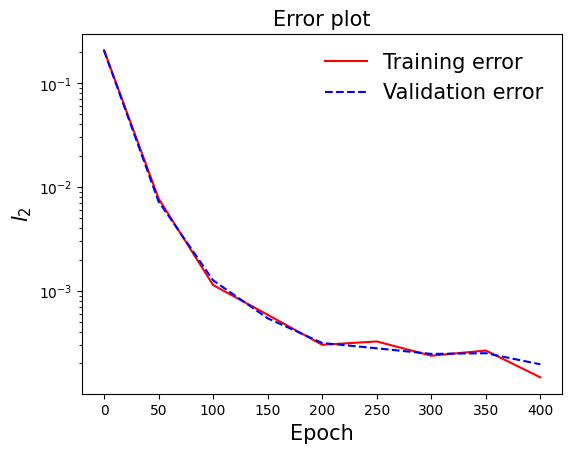

In [18]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_training_error.pdf", dpi=150)

In [19]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14ec92628130>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

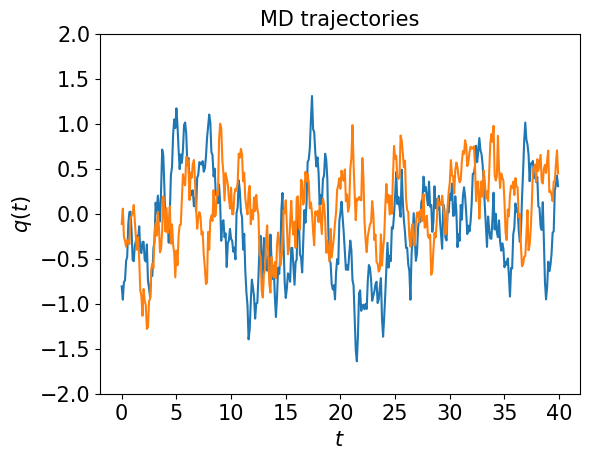

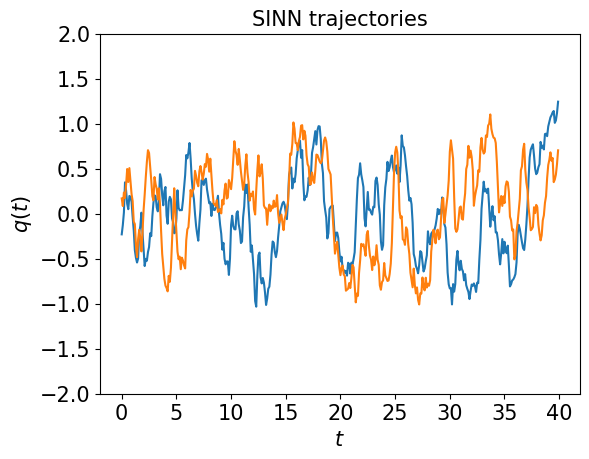

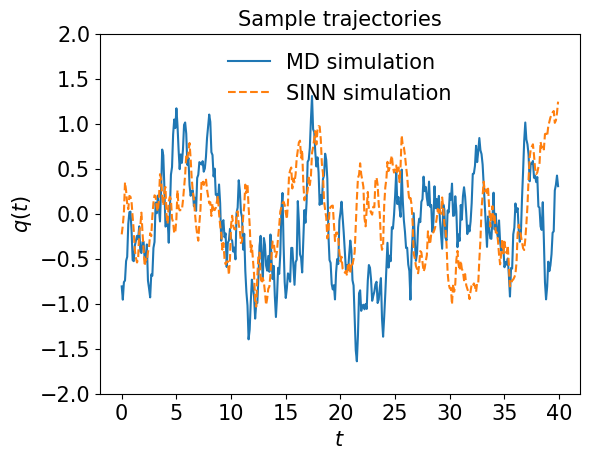

In [20]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

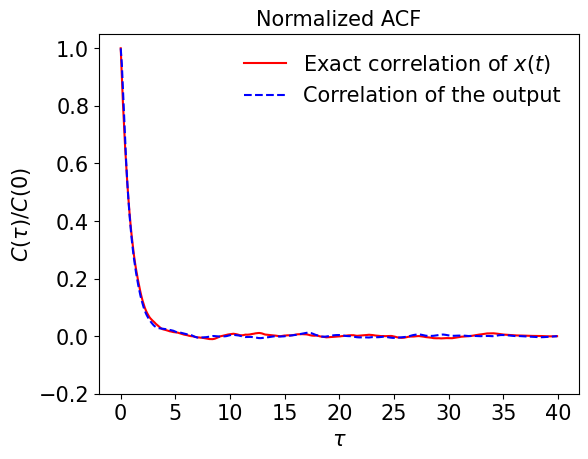

In [21]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 [Text(0, -0.1, '−0.1'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.20000000000000004, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5000000000000001, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

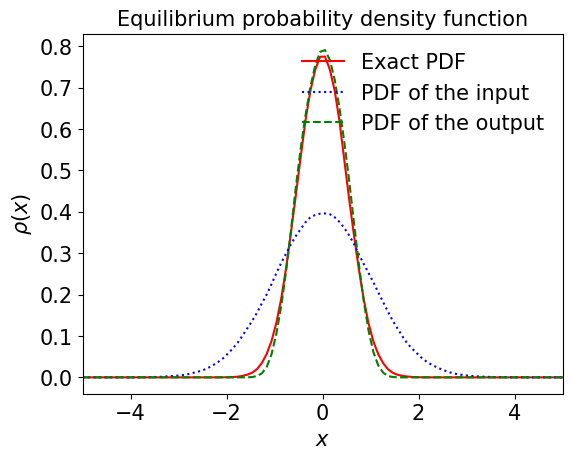

In [22]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

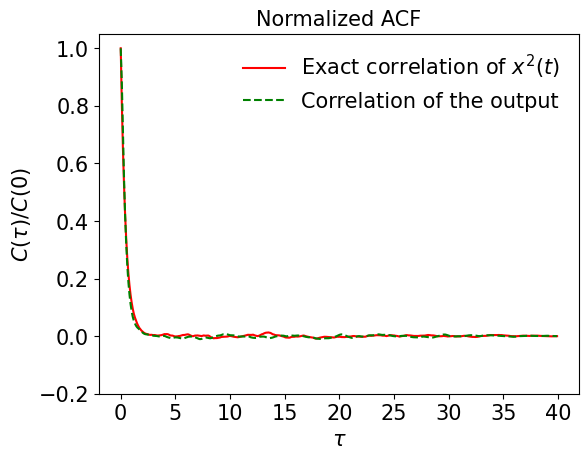

In [23]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf2.pdf", dpi=150)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500')])

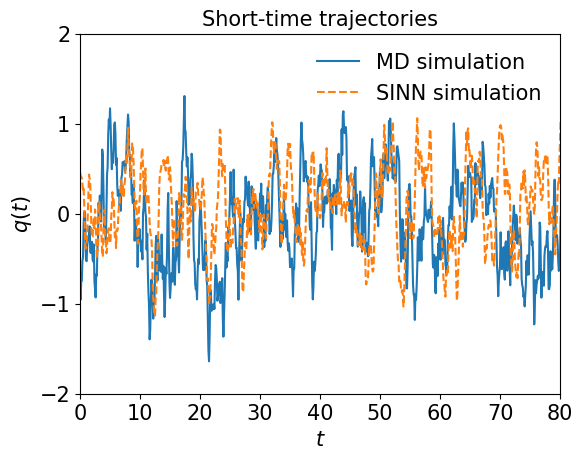

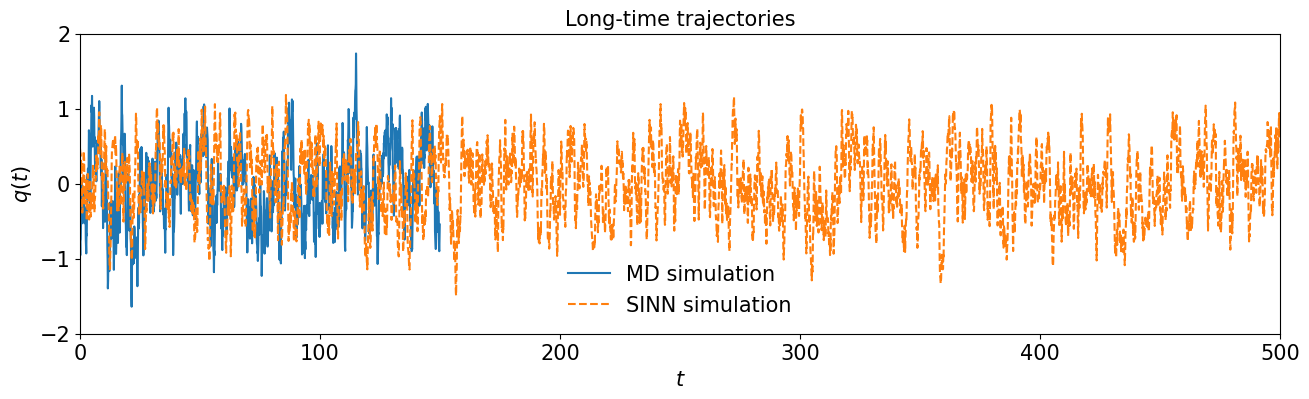

In [24]:
# Test 5: plot the expolation result, i.e. Prediction of the OU dynamics for longer time 

[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,80])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/OU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,500])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/OU_traj_lT.pdf", dpi=150)

In [25]:
### Defining SINN model 
net1 = SINN(1, 16, 2, 1,'GRU').to(device)
optimizer = optim.Adam(net1.parameters(), lr=1e-3)

In [26]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net1(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_exact(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net1(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0002 and loss_val<=0.0002:
            break
print('Training finished')

[0]-th step loss: 0.2398, 0.2355
[50]-th step loss: 0.0068, 0.0060
[100]-th step loss: 0.0016, 0.0017
[150]-th step loss: 0.0008, 0.0009
[200]-th step loss: 0.0004, 0.0004
[250]-th step loss: 0.0003, 0.0003
[300]-th step loss: 0.0002, 0.0003
[350]-th step loss: 0.0002, 0.0002
[400]-th step loss: 0.0002, 0.0002
[450]-th step loss: 0.0002, 0.0002
[500]-th step loss: 0.0002, 0.0002
Training finished
CPU times: user 10.9 s, sys: 36.2 ms, total: 11 s
Wall time: 11 s


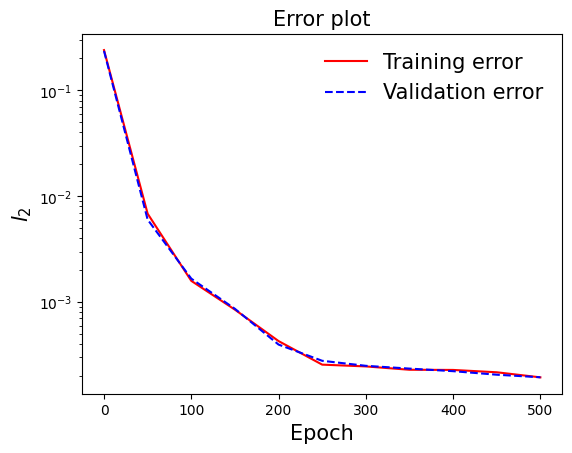

In [27]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [28]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net1(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14ec91ef0880>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

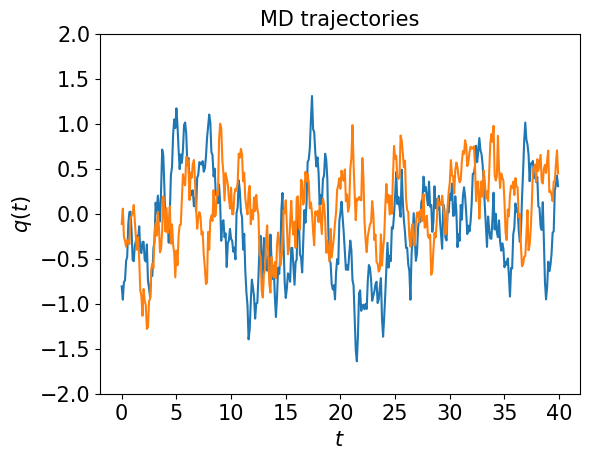

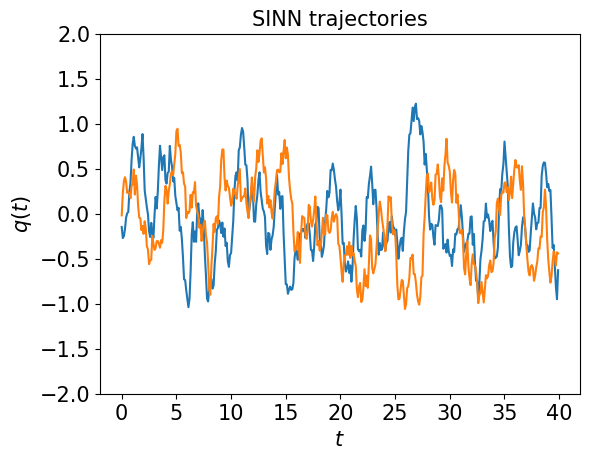

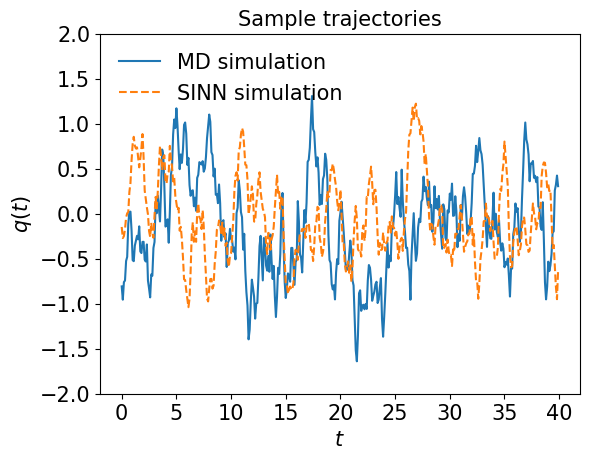

In [29]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

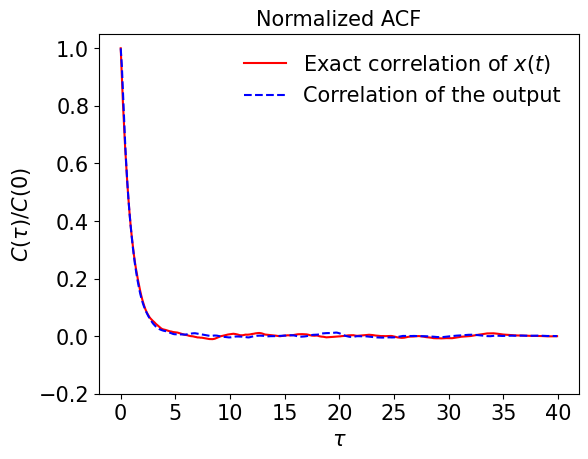

In [30]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 [Text(0, -0.1, '−0.1'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.20000000000000004, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5000000000000001, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

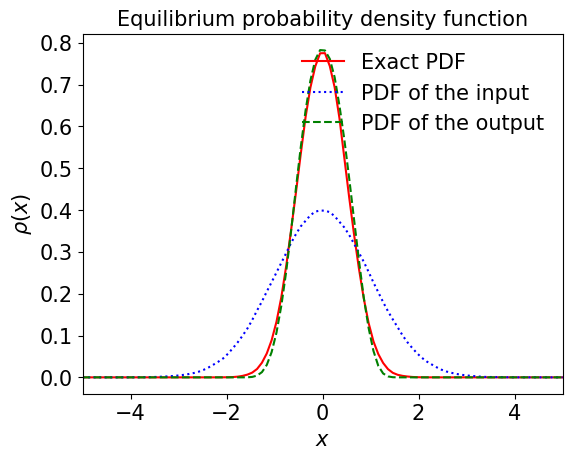

In [31]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

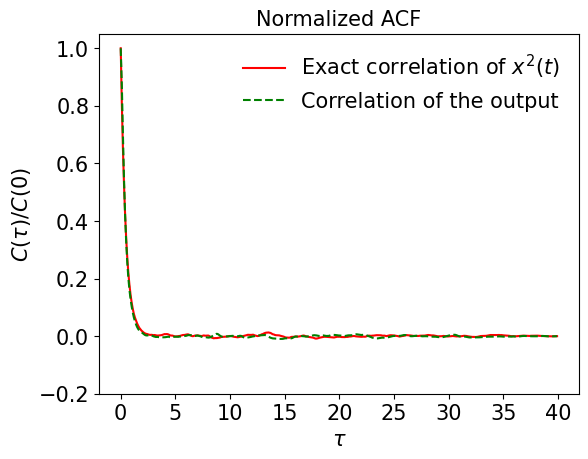

In [32]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf2.pdf", dpi=150)

In [33]:
### Defining SINN model 
net2 = SINN(1, 16, 2, 1,'GRU').to(device)
optimizer = optim.Adam(net2.parameters(), lr=1e-3)

In [34]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net2(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_exact(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net2(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0002 and loss_val<=0.0002:
            break
print('Training finished')

[0]-th step loss: 0.2142, 0.2129
[50]-th step loss: 0.0053, 0.0051
[100]-th step loss: 0.0020, 0.0022
[150]-th step loss: 0.0016, 0.0016
[200]-th step loss: 0.0008, 0.0009
[250]-th step loss: 0.0004, 0.0004
[300]-th step loss: 0.0003, 0.0003
[350]-th step loss: 0.0002, 0.0003
[400]-th step loss: 0.0002, 0.0002
[450]-th step loss: 0.0002, 0.0002
[500]-th step loss: 0.0002, 0.0002
Training finished
CPU times: user 10.9 s, sys: 34.6 ms, total: 10.9 s
Wall time: 11 s


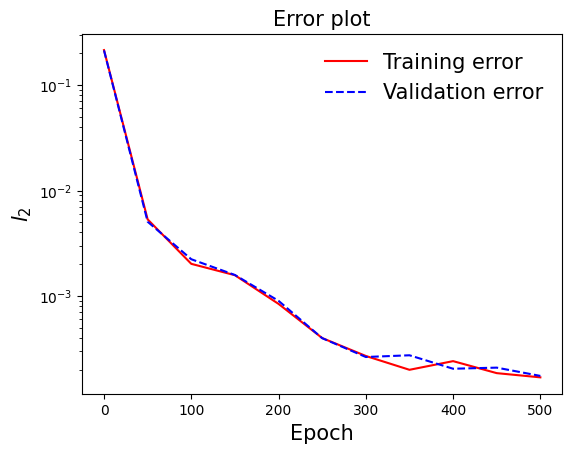

In [35]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [36]:
### Defining SINN model 
net3 = SINN(1, 16, 2, 1,'GRU').to(device)
optimizer = optim.Adam(net3.parameters(), lr=1e-3)

In [37]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net3(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_exact(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net3(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0002 and loss_val<=0.0002:
            break
print('Training finished')

[0]-th step loss: 0.2141, 0.2120
[50]-th step loss: 0.0046, 0.0040
[100]-th step loss: 0.0010, 0.0010
[150]-th step loss: 0.0004, 0.0005
[200]-th step loss: 0.0003, 0.0003
[250]-th step loss: 0.0003, 0.0002
[300]-th step loss: 0.0002, 0.0003
[350]-th step loss: 0.0002, 0.0002
[400]-th step loss: 0.0002, 0.0002
Training finished
CPU times: user 8.78 s, sys: 25.8 ms, total: 8.8 s
Wall time: 8.84 s


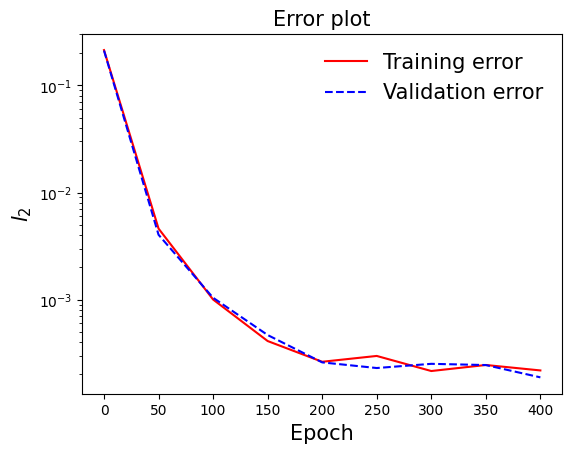

In [38]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [39]:
### Defining SINN model 
net4 = SINN(1, 16, 2, 1,'GRU').to(device)
optimizer = optim.Adam(net4.parameters(), lr=1e-3)

In [40]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net4(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_exact(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net4(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0002 and loss_val<=0.0002:
            break
print('Training finished')

[0]-th step loss: 0.2246, 0.2199
[50]-th step loss: 0.0068, 0.0064
[100]-th step loss: 0.0016, 0.0015
[150]-th step loss: 0.0009, 0.0011
[200]-th step loss: 0.0006, 0.0007
[250]-th step loss: 0.0005, 0.0005
[300]-th step loss: 0.0004, 0.0004
[350]-th step loss: 0.0003, 0.0003
[400]-th step loss: 0.0004, 0.0003
[450]-th step loss: 0.0003, 0.0003
[500]-th step loss: 0.0002, 0.0002
[550]-th step loss: 0.0003, 0.0002
[600]-th step loss: 0.0002, 0.0002
[650]-th step loss: 0.0002, 0.0002
[700]-th step loss: 0.0002, 0.0002
Training finished
CPU times: user 15.3 s, sys: 49.8 ms, total: 15.3 s
Wall time: 15.4 s


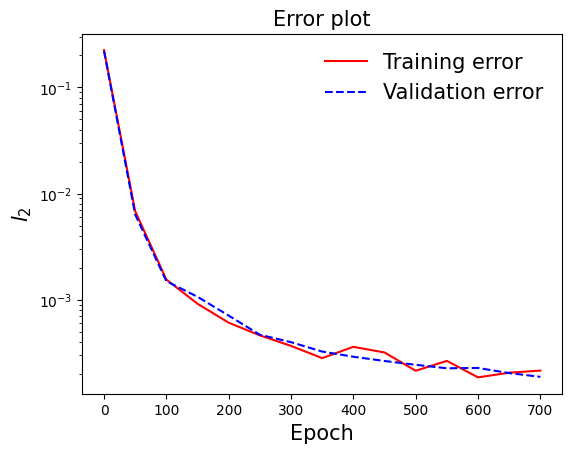

In [41]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [42]:
### Defining SINN model 
net5 = SINN(1, 16, 2, 1,'GRU').to(device)
optimizer = optim.Adam(net5.parameters(), lr=1e-3)

In [43]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net5(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_exact(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net5(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0002 and loss_val<=0.0002:
            break
print('Training finished')

[0]-th step loss: 0.2226, 0.2192
[50]-th step loss: 0.0103, 0.0097
[100]-th step loss: 0.0019, 0.0020
[150]-th step loss: 0.0009, 0.0010
[200]-th step loss: 0.0002, 0.0003
[250]-th step loss: 0.0002, 0.0002
Training finished
CPU times: user 5.48 s, sys: 13 ms, total: 5.5 s
Wall time: 5.52 s


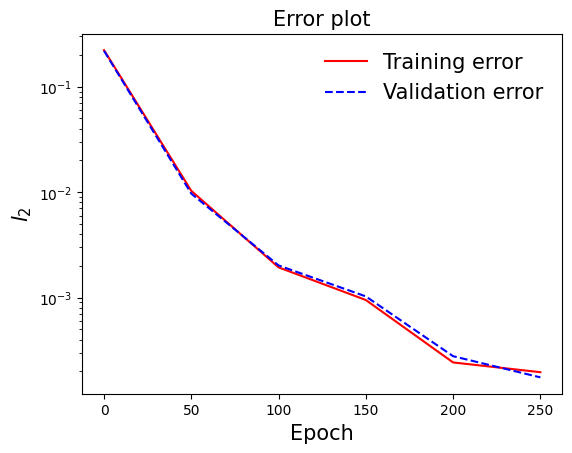

In [44]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [45]:
### Defining SINN model 
net6 = SINN(1, 16, 2, 1,'GRU').to(device)
optimizer = optim.Adam(net6.parameters(), lr=1e-3)

In [46]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net6(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_exact(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net6(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0002 and loss_val<=0.0002:
            break
print('Training finished')

[0]-th step loss: 0.2174, 0.2140
[50]-th step loss: 0.0114, 0.0101
[100]-th step loss: 0.0020, 0.0021
[150]-th step loss: 0.0014, 0.0014
[200]-th step loss: 0.0008, 0.0008
[250]-th step loss: 0.0004, 0.0005
[300]-th step loss: 0.0003, 0.0003
[350]-th step loss: 0.0003, 0.0003
[400]-th step loss: 0.0003, 0.0002
[450]-th step loss: 0.0002, 0.0002
[500]-th step loss: 0.0002, 0.0002
Training finished
CPU times: user 10.9 s, sys: 26.8 ms, total: 10.9 s
Wall time: 11 s


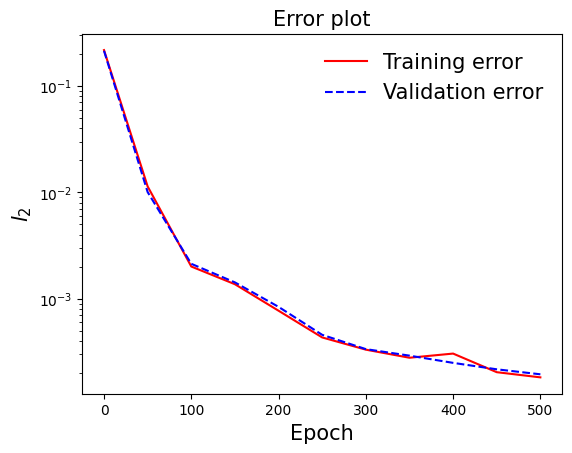

In [47]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [48]:
### Defining SINN model 
net7 = SINN(1, 16, 2, 1,'GRU').to(device)
optimizer = optim.Adam(net7.parameters(), lr=1e-3)

In [49]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net7(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_exact(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net7(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0002 and loss_val<=0.0002:
            break
print('Training finished')

[0]-th step loss: 0.2093, 0.2040
[50]-th step loss: 0.0053, 0.0048
[100]-th step loss: 0.0021, 0.0020
[150]-th step loss: 0.0012, 0.0013
[200]-th step loss: 0.0006, 0.0006
[250]-th step loss: 0.0002, 0.0003
[300]-th step loss: 0.0003, 0.0002
[350]-th step loss: 0.0002, 0.0002
Training finished
CPU times: user 7.69 s, sys: 18.9 ms, total: 7.71 s
Wall time: 7.74 s


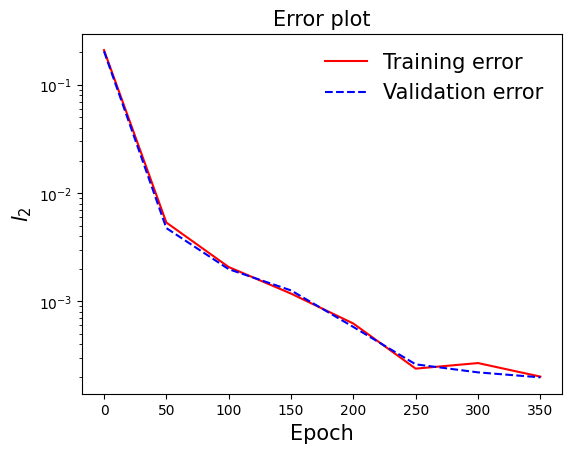

In [50]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [51]:
### Defining SINN model 
net8 = SINN(1, 16, 2, 1,'GRU').to(device)
optimizer = optim.Adam(net8.parameters(), lr=1e-3)

In [52]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net8(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_exact(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net8(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0002 and loss_val<=0.0002:
            break
print('Training finished')

[0]-th step loss: 0.1930, 0.1882
[50]-th step loss: 0.0048, 0.0047
[100]-th step loss: 0.0017, 0.0018
[150]-th step loss: 0.0011, 0.0011
[200]-th step loss: 0.0005, 0.0005
[250]-th step loss: 0.0004, 0.0004
[300]-th step loss: 0.0003, 0.0003
[350]-th step loss: 0.0003, 0.0003
[400]-th step loss: 0.0003, 0.0003
[450]-th step loss: 0.0003, 0.0002
[500]-th step loss: 0.0002, 0.0002
[550]-th step loss: 0.0002, 0.0002
[600]-th step loss: 0.0002, 0.0002
Training finished
CPU times: user 13.1 s, sys: 38.8 ms, total: 13.1 s
Wall time: 13.2 s


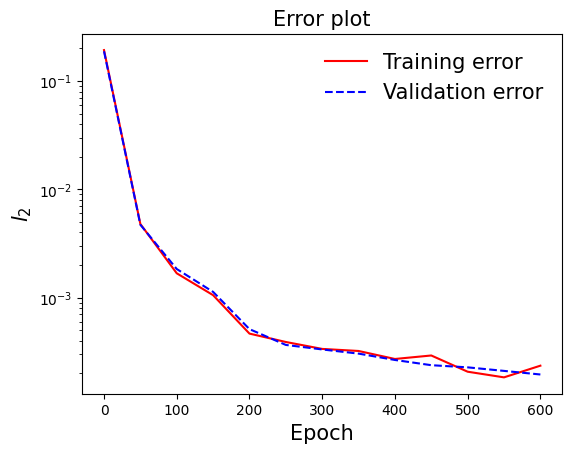

In [53]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [54]:
### Defining SINN model 
net9 = SINN(1, 16, 2, 1,'GRU').to(device)
optimizer = optim.Adam(net9.parameters(), lr=1e-3)

In [55]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net9(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_exact(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net9(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0002 and loss_val<=0.0002:
            break
print('Training finished')

[0]-th step loss: 0.2117, 0.2112
[50]-th step loss: 0.0161, 0.0140
[100]-th step loss: 0.0014, 0.0015
[150]-th step loss: 0.0010, 0.0010
[200]-th step loss: 0.0007, 0.0007
[250]-th step loss: 0.0005, 0.0006
[300]-th step loss: 0.0005, 0.0005
[350]-th step loss: 0.0004, 0.0004
[400]-th step loss: 0.0004, 0.0004
[450]-th step loss: 0.0003, 0.0003
[500]-th step loss: 0.0003, 0.0003
[550]-th step loss: 0.0003, 0.0003
[600]-th step loss: 0.0002, 0.0002
[650]-th step loss: 0.0002, 0.0002
Training finished
CPU times: user 14.2 s, sys: 35.8 ms, total: 14.2 s
Wall time: 14.3 s


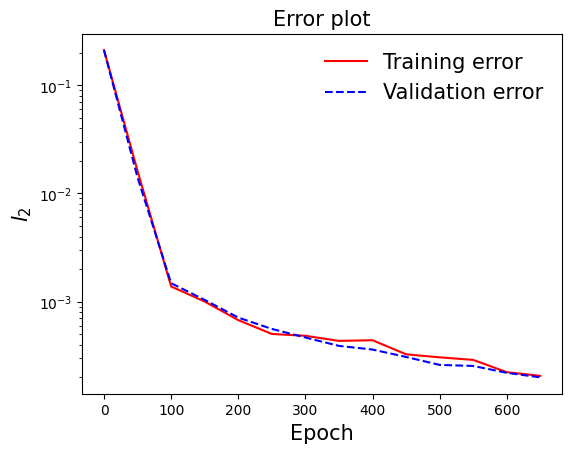

In [56]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

# END